In [48]:
import tarfile # 처음에만 실행
tar = tarfile.open("mnist_png.tar.gz")
tar.extractall()
tar.close()

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import v2
from sklearn.metrics import *
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import glob

device = torch.device("cuda")
device

device(type='cuda')

#  0. Augmentation visualizing

In [3]:
samples = []
for i in range(5):
    path = glob.glob(f'./mnist_png/training/{i}/*.png')[0]
    img = Image.open(path)
    samples.append(img)
samples

[<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>]

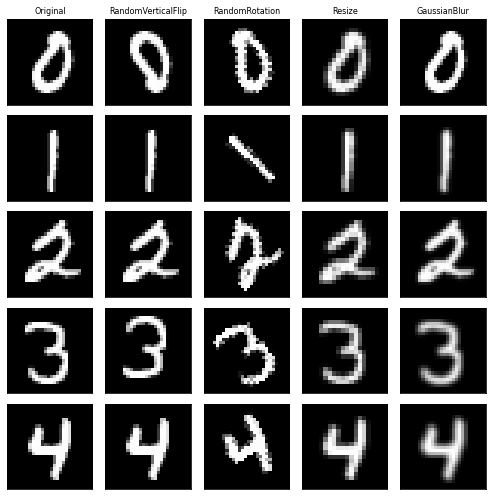

In [4]:
fig, ax = plt.subplots(5,5, figsize=(7, 7))
for i in range(5):
    img = samples[i]
    for j in range(5):
        if j!=0:
            if j==1:
                transform = v2.RandomVerticalFlip(p=0.5)
            elif j==2:
                transform = v2.RandomRotation(degrees=(0, 60))
            elif j==3:
                transform = v2.Resize(size=20)
            else:
                transform = v2.GaussianBlur(kernel_size=(3,3))
            aug_img = transform(img)
        else:
            aug_img = img
        
        ax[i, j].imshow(aug_img, cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
ax[0, 0].set_title("Original", fontdict={'fontsize':8})
ax[0, 1].set_title("RandomVerticalFlip", fontdict={'fontsize':8})
ax[0, 2].set_title("RandomRotation", fontdict={'fontsize':8})
ax[0, 3].set_title("Resize", fontdict={'fontsize':8})
ax[0, 4].set_title("GaussianBlur", fontdict={'fontsize':8})

fig.tight_layout()
plt.show()

# 1. CustomDataset

In [45]:
class CustomDataset(Dataset):
    def __init__(self, file_path, train=None, transform=None):
        super().__init__()
        self.labels = []
        self.file_path = file_path
        self.transform = transform
        
        if train:
            csv = pd.read_csv('csv_label.csv', header=None)
        else:
            csv = pd.read_csv('csv_label_test.csv', header=None)
            csv = csv.drop(0, axis=1)
        csv = np.array(csv)
        for i in range(len(csv)):
            for cls in range(10):
                if csv[i][cls]==1:
                    self.labels.append(cls)
        self.labels = np.array(self.labels)
    
    def __len__(self):
        return len(self.file_path)
    
    def __getitem__(self, idx):
        file = self.file_path[idx]
        img = Image.open(file)
        if self.transform and self.labels[idx]==5: # '5' class augmentation 
            img = self.transform(img)
        else:
            self.transform = v2.Compose([
                v2.ToImageTensor(), 
                v2.ConvertImageDtype()])
            img = self.transform(img)
        return img, self.labels[idx]

In [91]:
train_path = glob.glob('./mnist_png/training/*/*.png')
test_path = glob.glob('./mnist_png/testing/*/*.png')

transform = v2.Compose([v2.RandomRotation(degrees=(0, 60)), 
                        v2.ToImageTensor(), 
                        v2.ConvertImageDtype()])

train_dataset = CustomDataset(file_path=train_path, train=True, transform=transform)
test_dataset = CustomDataset(file_path=test_path, train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, drop_last=True) # shuffle X

# 2. Model Configuration/Training

In [93]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [94]:
epochs = 30
loss_history = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        train_loss += loss
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader)
    loss_history.append(avg_train_loss.cpu().detach().numpy())
    print(f"Epochs : {epoch+1}, loss : {avg_train_loss:.5f}")

Epochs : 1, loss : 1.38444
Epochs : 2, loss : 0.64913
Epochs : 3, loss : 0.55538
Epochs : 4, loss : 0.50409
Epochs : 5, loss : 0.46630
Epochs : 6, loss : 0.43773
Epochs : 7, loss : 0.41525
Epochs : 8, loss : 0.39679
Epochs : 9, loss : 0.38133
Epochs : 10, loss : 0.36862
Epochs : 11, loss : 0.35660
Epochs : 12, loss : 0.34707
Epochs : 13, loss : 0.33843
Epochs : 14, loss : 0.33082
Epochs : 15, loss : 0.32373
Epochs : 16, loss : 0.31717
Epochs : 17, loss : 0.31139
Epochs : 18, loss : 0.30628
Epochs : 19, loss : 0.30069
Epochs : 20, loss : 0.29666
Epochs : 21, loss : 0.29281
Epochs : 22, loss : 0.28846
Epochs : 23, loss : 0.28463
Epochs : 24, loss : 0.28081
Epochs : 25, loss : 0.27777
Epochs : 26, loss : 0.27397
Epochs : 27, loss : 0.27122
Epochs : 28, loss : 0.26842
Epochs : 29, loss : 0.26521
Epochs : 30, loss : 0.26290


In [95]:
# test pred
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)
        output = model(x)
        preds.append(np.argmax(output.cpu().numpy(), axis=1))
        
targets = test_dataset.labels[:9984]
preds = np.array(preds).flatten()

In [96]:
report = classification_report(targets, preds, output_dict=True)
df = pd.DataFrame(report)
df

,0,1,2,3,4,5,6,7,8,9,accuracy,macro avg,weighted avg
precision,0.851232,0.902256,0.918172,0.969595,0.907723,0.846540,0.815185,0.865927,0.910678,0.976861,0.894832,0.896417,0.897620
recall,0.986735,0.845815,0.837209,0.852475,0.921589,0.963470,0.851775,0.835603,0.910678,0.962339,0.894832,0.896769,0.894832
f1-score,0.913989,0.873124,0.875824,0.907271,0.914603,0.901228,0.833078,0.850495,0.910678,0.969546,0.894832,0.894983,0.894650
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,876.000000,958.000000,1028.000000,974.000000,1009.000000,0.894832,9984.000000,9984.000000


In [98]:
a = df[['macro avg']]
a.columns = ['RandomRotation']
a = a.drop(['support'])
a.loc['accuracy'] = df['accuracy']['precision']
a = a.transpose()
a.to_csv("RandomRotation.csv")
a

,precision,recall,f1-score,accuracy
RandomRotation,0.896417,0.896769,0.894983,0.894832


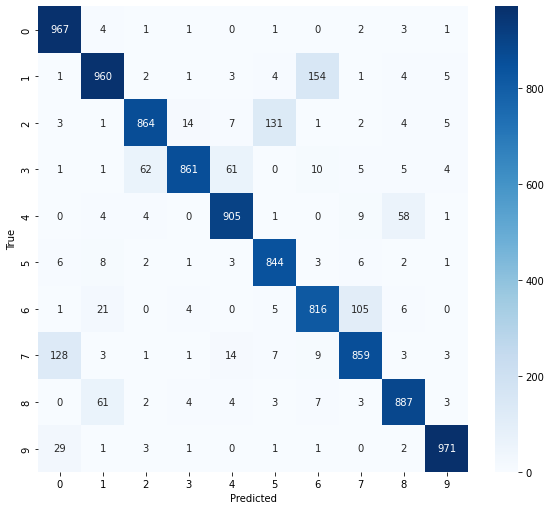

In [99]:
cm = confusion_matrix(targets, preds)

# heatmap value : 표본의 수
plt.figure(figsize=(8,7))
sns.heatmap(cm, annot=True,annot_kws={"size":10}, cmap='Blues', fmt="d")
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()